<a href="https://colab.research.google.com/github/mnsv73/PM2.5-Prediction/blob/master/Station1001_enc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Autoencoder Model for data completion

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers
import random
import tensorflow as tf
#tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Using TensorFlow backend.


In [0]:
#Data Loading
data = pd.read_excel('/content/drive/My Drive/AQI Prediction/AQI Project/data2/station1001_1.xlsx')
x = data.drop(['PM25_Concentration', 'time'], axis=1)
y = data.drop(['PM25_Concentration', 'time'], axis=1)
z=x.isnull().any(axis=1)
z

0       False
1       False
2       False
3       False
4       False
        ...  
7383    False
7384    False
7385    False
7386    False
7387    False
Length: 7388, dtype: bool

In [0]:
x1 = pd.DataFrame(columns = [])
y1 = pd.DataFrame(columns = [])
for i in range(len(x)):
  if z[i]==False:
    x1=x1.append(x.iloc[i], ignore_index=True)
    y1=y1.append(y.iloc[i], ignore_index=True)
x1.shape

(2542, 7)

In [0]:
#Normalizing
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x1)
y_scaled = min_max_scaler.fit_transform(y1)
#Input data Manipulation(creating random -1 so that we can predict their values) (this all is for data completion)
for i in range(len(x_scaled)):
    idx = random.choice([0,1,2,3,4,5])
    x_scaled[i][idx]=-1


In [0]:
#Autoencoder Model
model = Sequential()
model.add(Dense(units = 4, kernel_initializer = "uniform", activation = "sigmoid", input_dim = 7, activity_regularizer = regularizers.l2(0.01)))
model.add(Dropout(rate = 0.05))
model.add(Dense(units = 2, kernel_initializer = "uniform", activation = "sigmoid"))
model.add(Dense(units = 4, kernel_initializer = "uniform", activation = "sigmoid"))
model.add(Dense(units = 7, kernel_initializer = "uniform", activation = "sigmoid"))
from keras import backend as K

def mse(y_true, y_pred):
    return K.sum((y_true-y_pred)**2,axis=-1)
model.compile(optimizer = "rmsprop", loss = mse, metrics=['accuracy'])
history = model.fit(x_scaled, y_scaled, batch_size = 16, epochs = 500, validation_split = 0.1)

Train on 2287 samples, validate on 255 samples
Epoch 1/500
2287/2287 [==============================] - 0s 217us/step - loss: 0.6634 - accuracy: 0.2575 - val_loss: 0.5115 - val_accuracy: 0.3608
Epoch 2/500
2287/2287 [==============================] - 0s 80us/step - loss: 0.4966 - accuracy: 0.2680 - val_loss: 0.3745 - val_accuracy: 0.3608
Epoch 3/500
2287/2287 [==============================] - 0s 82us/step - loss: 0.4126 - accuracy: 0.2680 - val_loss: 0.3146 - val_accuracy: 0.3608
Epoch 4/500
2287/2287 [==============================] - 0s 79us/step - loss: 0.3784 - accuracy: 0.2680 - val_loss: 0.2900 - val_accuracy: 0.3608
Epoch 5/500
2287/2287 [==============================] - 0s 78us/step - loss: 0.3613 - accuracy: 0.2680 - val_loss: 0.2775 - val_accuracy: 0.3608
Epoch 6/500
2287/2287 [==============================] - 0s 81us/step - loss: 0.3506 - accuracy: 0.2680 - val_loss: 0.2675 - val_accuracy: 0.3608
Epoch 7/500
2287/2287 [==============================] - 0s 80us/step - loss

In [0]:
y_new  = model.predict(x_scaled)

In [0]:
scores = model.evaluate(x_scaled, y_scaled, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

2542/2542 [==============================] - 0s 24us/step
Test loss: 0.2202752635269818
Test accuracy: 0.595594048500061


dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


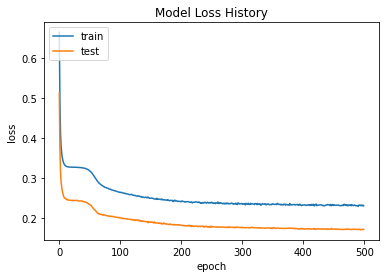

In [0]:
#Loss Function changes while training
print(history.history.keys())
plt.plot(history.history['loss'])    #i dont get this i am not sure about these results
plt.plot(history.history['val_loss'])
plt.title('Model Loss History')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

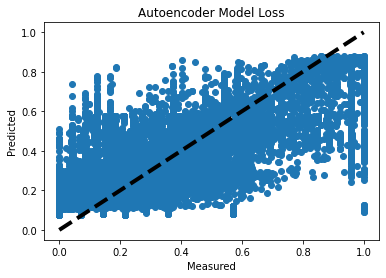

In [0]:
#Meaured v/s Predicted Value
fig, ax = plt.subplots()
ax.scatter(y_scaled, y_new)
ax.plot([y_scaled.min(), y_scaled.max()], [y_scaled.min(), y_scaled.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title('Autoencoder Model Loss')
plt.show()

In [0]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_scaled, y_new)

ValueError: ignored

In [0]:
#Save model results
model_json = model.to_json()
with open("/content/drive/My Drive/AQI Prediction/AQI Project/data2/model.json","w") as json_file:
    json_file.write(model_json)
model.save_weights("/content/drive/My Drive/AQI Prediction/AQI Project/data2/station1enc.h5")
print("Saved model to disk")

Saved model to disk
